<h1>
    <center>
    TMA4215 Project 2


### Table of contents
#### 1. Introduction
#### 2. Algorithm 
#### 3. Deciding parameters
3.1 Number of hidden layers, $K$

3.2 


#### 3. Testing on suggested functions
3.1 $F(y) = 1-\cos(y)$

3.2 $G(y) = \frac{1}{2}(y_1^2 + y_2^2)$

### 1. Introduction

The purpose of this project is to use a neural network to train approximations of Hamiltonian function, derive and implement formulas for computing the gradient of the trained function and use those to implement symplectic Euler and the Størmer-Verlet method for the Hamiltonian function. 

This report present the algorithm, ...

### 2. Algorithm

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mpl_toolkits.mplot3d import Axes3D

In [21]:
from project_2_data_acquisition import generate_data, concatenate
from files import writeParams, readParams

The functions above are imported from separate files and are used to generate input data batches from comma seperated files and to write our trained values to a file as well as reading these values from a file. 

The algorithm is divided into several smaller codeblocks with the purpose of making the code easy to follow. Principally, the algorithm's parts is to transform input data between the layers in the network, decide the gradients of the objective function, $J = \frac{1}{2} \|Z-c\| $, with respect to weights, biases, $\omega$ and $\mu$ and optimalize the network with respect to those. Additionally, several utility functions is defined to be used in the algorithm.

In [22]:
def getW(K,d):
    w = np.random.randn(K,d,d)
    return w

def getb(K,d):
    b = np.random.randn(K,d,1)
    return b

def getomega(d):
    omega = np.random.randn(d,1)
    return omega

def getmu():
    mu = np.random.randn(1)
    return mu

The functions above generate random initial values drawn from a standard normal distribution to the weights, $W_k$, the biases, $b_k$, $\omega$ and $\mu$. These random values causes some marginal differences between runs of the same dataset. 

In [23]:
def getZ(Y0, W, b, K, d, I, h, sigma):
    #initialize Z, Z0=Y0
    Z = np.zeros((K+1,d,I))
    Z[0] = Y0

    #finds Zk
    for k in range(1,K+1):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def getP(Z, ypsilon, c, omega, mu, W, b, K, d, I, h, sigma_div, eta_div):
    #initialize P
    P = np.zeros((K+1,d,I))

    #finds P_K
    u = np.transpose(Z[-1])@omega + mu
    P[-1]= omega@np.transpose((ypsilon-c)*eta_div(u))

    #finds P_K-1 to P_0
    for k in range(K-1,0,-1):
        s = W[k]@Z[k] + b[k]
        P[k]=P[k+1] + h*np.transpose(W[k])@(sigma_div(s)*P[k+1])
        
    return P


def getYpsilon(Z, omega, mu, K, eta):
    u = np.transpose(Z[K]) @ omega + mu
    return eta(u)

def getJ(ypsilon, c):
    return 1/2 * np.linalg.norm(ypsilon-c)**2

Defines the functions getZ and getP, where getZ executes linear transformations $\Phi_k: Z_k \rightarrow Z_{k+1}$ based on the weights and biases and returns the matrix $Z$ and getP returns an utility matrix used in calulations of derivatives of the objective function with respect to the weight and biases. Furthermore, getYpsilon is defined and returns a vector of the function values in the last layer in the network and the objective funksjon $J$ is defined as a measure of the difference between the resulting trained values and the exact function values. 

In [24]:
def getdJdmu(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdmu = np.transpose(eta_div(u))@(ypsilon-c)
    return dJdmu

def getdJdomega(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdOmega = Z[K] @ ((ypsilon - c) * eta_div(u))
    return dJdOmega

def getdJdW(P, Z, W, b, K, h, sigma_div):
    dJdW = np.zeros_like(W)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdW[k] = h*(P[k+1]*sigma_div(u))@ np.transpose(Z[k])  
    return dJdW

def getdJdb(P, Z, W, b, K, h, sigma_div):
    dJdb = np.zeros_like(b)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdb[k] = h*(P[k+1]*sigma_div(u))@np.ones((Z.shape[2],1))
    return dJdb

Functions to obtain the derivatives of the objective function with respect to weights and biased is defined. 

In [25]:
def getMandV(theta):
    return np.zeros_like(theta),np.zeros_like(theta)

def plain(theta, tau, dJdtheta):
    return theta - tau*dJdtheta

def adam(theta,alpha,m,v,g,i):
    #parameters
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 10E-8

    #m,v
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*np.multiply(g,g)

    m_hat = np.multiply(m,1/(1-beta1**i))
    v_hat = np.multiply(v,1/(1-beta2**i))

    #update
    R = alpha*np.multiply(m_hat,1/(np.sqrt(v_hat)+epsilon))

    return theta-R,m,v

The functions above is used to optimize the weights, biases, $\omega$ and $\mu$ in different ways, which will be compared later on in this report.

In plain vanilla gradient descent, one follows the gradient in decreasing direction and the learning parameter $\tau$ determine how far one shall follow it. 

In Adam descent method, one follows the gradient with different length depending on different parameters. The parameters $m$ and $v$ represent respectively a kind of mean value and squared mean value of the previous iterations gradients. The function getMandV initialize $m$ and $v$ to be either zer, the zerovector or the zeromatrix depending on inputdata's dimension. 

In [26]:
def sigma(x):
    return np.tanh(x)

def sigma_div(x):
    return 1 - np.tanh(x)**2

def eta(x):
    return 1/2*(1+np.tanh(x/2))

def eta_div(x):
    return 1/(4*np.cosh(x/2)**2) 

Above, the activating function $\sigma$, which is used in the transformation $\Phi_k: Z_k \rightarrow Z_{k+1}$, and the function $\eta$, used in projection from last layer on a scalar $z$, is defined. The derivatives of $\sigma$ and $\eta$ is also defined and will be used in calculations of the gradient of the objective function.

In [27]:
def scale(x, alpha=0.2, beta=0.8):
    a = np.amin(x)
    b = np.amax(x)
    
    x_tilde = 1/(b-a)*((b-x)*alpha + (x-a)*beta)
    return x_tilde, a, b

def inverseScale(x_tilde, a, b, alpha=0.2, beta=0.8):
    return 1/(beta-alpha)*((x_tilde-alpha)*b + (beta-x_tilde)*a)

A function to scale data in terms of a min-max transformation that guaranteed that the data have all its components in the interval $[\alpha, \beta]$ is defined. This is desirable since some functions is acting component-wise on other functions....?

In [28]:
def successrate(ypsilon, c, tol):
    sum = 0
    for i in range(ypsilon.shape[0]):
        if isclose(ypsilon[i][0], c[0][i], abs_tol = tol):
            sum +=1
    return sum/ypsilon.shape[0]

si noe fornuftig her etterhver

In [29]:
def trainingAlgorithm(K, d, h, tau, Y0, c0, eta, sigma, eta_div, sigma_div, N, tol, chunksize, optimization):
    #finds input shape
    d0 = Y0.shape[0]
    I0 = Y0.shape[1]
    
    #reshapes input to match dimension of layers
    if d0 > d:
        return "d must be larger than d0"
    
    if d0 < d:
        zero = np.zeros((d-d0,I0))
        Y0 = np.vstack((Y0,zero))
    
    #gets initial weigths
    omega = getomega(d)
    mu = getmu()
    W = getW(K,d)
    b = getb(K,d)
    
    c0 = np.transpose(c0)
  
    if optimization == "adam":
        #initial m,v for adam descent
        mmu,vmu = getMandV(mu)
        momega,vomega =getMandV(omega)
        mW,vW = getMandV(W)
        mb,vb = getMandV(b)
    
    #initializes vector to store objective function values
    J = np.zeros(N)
    ypsilon = np.zeros_like(c0)
    
    for i in range(N):
               
        #stochastic gradient descent
        if I0 == chunksize:
            Y0_chunk = Y0
            c_chunk = c0
        elif I0 > chunksize:
            s = np.random.randint(0,I0-chunksize)
            Y0_chunk = Y0[:,s:(s+chunksize)]
            c_chunk=c0[s:(s+chunksize),:]
        else:
            return "chunksize must be smaller than I"        
        

        #transformations between layers
        Z = getZ(Y0_chunk, W, b, K, d, chunksize, h, sigma)
        ypsilon = getYpsilon(Z, omega, mu, K, eta)
        P = getP(Z, ypsilon, c_chunk, omega, mu, W, b, K, d, chunksize, h, sigma_div, eta_div)
        
        #objective function
        J[i] = getJ(ypsilon, c_chunk)
        
        #finds gradients
        dJdmu = getdJdmu(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdomega = getdJdomega(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdW = getdJdW(P, Z, W, b, K, h, sigma_div)
        dJdb = getdJdb(P, Z, W, b, K, h, sigma_div)
        
        if optimization == "plain":
            mu = plain(mu, tau, dJdmu)
            omega = plain(omega, tau, dJdomega)
            W = plain(W, tau, dJdW)
            b = plain(b, tau, dJdb)
        
        elif optimization == "adam":
            mu, mmu,vmu = adam(mu,tau,mmu,vmu,dJdmu,i+1)
            omega, momega,vomega = adam(omega,tau,momega,vomega,dJdomega,i+1)
            W, mW,vW = adam(W,tau,mW,vW,dJdW,i+1)
            b, mb,vb = adam(b,tau,mb,vb,dJdb,i+1)
        
        if (J[i]/chunksize) < tol:
            break
        
    return mu, omega, W, b, J, ypsilon, i

In [30]:
def testing(yTest, cTest, W, b, omega, mu, K, d, I, h, sigma, eta):

    #scaling of input
    yTilde, aY, bY = scale(yTest)
    cTilde, ac, bc = scale(cTest)

    #finds input shape
    d0 = yTest.shape[0]
    
    if d > d0:
        zero = np.zeros((d-d0,I))
        yTilde = np.vstack((yTilde,zero))
    
    zTest = getZ(yTilde, W, b, K, d, I, h, sigma)
    ypsilonTilde = getYpsilon(zTest, omega, mu, K, eta)

    #rescaling of input
    ypsilonTest = inverseScale(ypsilonTilde, ac, bc)

    return ypsilonTest

The training algorithm returns trained values of the weights, biases, $\omega$ and $\mu$ as well as the objective function and $\Upsilon$. 

### 3. Deciding parameters

In [ ]:
I = 1000      
N = 2500
tol = 1E-10

#### 3.0 Batchsize

In [ ]:
#General for all test
N = 2500
tol = 1E-10
K = 50
batch0 = generate_data(0)

p0_tilde, ap0,bp0 = scale(batch0['P'])
T0_tilde, aT0, bT0 = scale(batch0['T'])
T0_tilde.resize(1,T0_tilde.shape[0])

In [ ]:
batchsize_list = np.arange(I_0/4, I_0+1,I_0/4).astype(int) 
d_0 = p0_tilde.shape[0]      #dimension of layers for F(y)
h = 0.1      #stepsize
tau = 0.0001   #learning parameter


fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

ax = axs[0]
#Adam
for i in range(len(batchsize_list)):
    #training with different K with adam
    batchsize = batchsize_list[i]
    mu_0, omega_0, W_0, b_0, J_batch, ypsilon_0, itr_0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    
    ax.plot(np.linspace(0,N,N), J_batch/batchsize, label = r"$batchsize ={}$".format(batchsize))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()


ax = axs[1]
#Plain
for i in range(len(batchsize_list)):
    #training with different K with plain
    batchsize = batchsize_list[i]
    mu_0, omega_0, W_0, b_0, J_batch_plain, ypsilon_0, itr_0  = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N,tol, batchsize, "plain")
    ax.plot(np.linspace(0,N,N), J_batch_plain/batchsize, label = r"$batchsize ={}$".format(batchsize))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

In [ ]:
batchsize_list = np.arange(I_0/4, I_0+1,I_0/4).astype(int) 
d_0 = p0_tilde.shape[0]      #dimension of layers for F(y)
h = 0.1      #stepsize
tau = 0.0001   #learning parameter


#Adam
filenames_batchsize_A = []
filenames_batchsize_P = []
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    filenames_batchsize_A.append('trainingParams_A{}'.format(batchsize))
    filenames_batchsize_P.append('trainingParams_P{}'.format(batchsize))
    #training with different K with adam
    mu_A0, omega_A0, W_A0, b_A0, J_Abatch, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Abatch, itr_A0, filename = filenames_batchsize_A[i])
    #training with different K with plain
    mu_P0, omega_P0, W_P0, b_P0, J_Pbatch, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Pbatch, itr_P0, filename = filenames_batchsize_P[i])

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)
ax = axs[0]

#plot adam
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_A0, itr_A0 = readParams(K, d_0, batchsize, N, filename = filename_batchsize_A[i])
    ax.plot(np.linspace(0,N,N), J_Abatch/batchsize, label = r"$batchsize ={}$".format(batchsize))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()


ax = axs[1]
#plot plain
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_P0, itr_P0 = readParams(K, d_0, batchsize, N, filename = filename_batchsize_P[i])
    ax.plot(np.linspace(0,N,N), J_Pbatch/batchsize, label = r"$batchsize ={}$".format(batchsize))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

#### 3.1 Number of hidden layers, $K$

In [ ]:
K_list = np.arange(25,101,25)      #number of hidden layers
d_0 = p0_tilde.shape[0]      #dimension of layers for F(y)
h = 0.1      #stepsize
tau = 0.001   #learning parameter
batchsize = I_0


fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

ax = axs[0]
#Adam
for i in range(len(K_list)):
    #training with different K with adam
    K = K_list[i]
    mu_0, omega_0, W_0, b_0, J_K, ypsilon_0, itr_0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol,batchsize, "adam")

    ax.plot(np.linspace(0,N,N), J_K/batchsize, label = r"$K ={}$".format(K))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()
    


ax = axs[1]
#Plain
for i in range(len(K_list)):
    #training with different K with plain
    K = K_list[i]
    mu_0, omega_0, W_0, b_0, J_K_plain, ypsilon_0, itr_0  = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N,tol, batchsize, "plain")
    ax.plot(np.linspace(0,N,N), J_K_plain/batchsize, label = r"$K ={}$".format(K))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

In [ ]:
old below 

In [ ]:
Y0_F = np.linspace(-2,2,I)
Y0_F.resize(1,I)
c_F = F(Y0_F)

Y0_F_tilde, aY0_F, bY0_F = scale(Y0_F)
c_F_tilde, ac_F, bc_F = scale(c_F)

Y0_G = np.random.uniform(-2,2,(2,I))
c_G = G(Y0_G[0],Y0_G[1])
c_G.resize(1,I)

Y0_G_tilde, aY0_G, bY0_G = scale(Y0_G)
c_G_tilde, ac_G, bc_G = scale(c_G)

In [ ]:
K_list = np.arange(25,101,25)      #number of hidden layers
d_F = 2      #dimension of layers for F(y)
h = 0.1      #stepsize
tau = 0.001   #learning parameter


fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

ax = axs[0]
#Adam
for i in range(len(K_list)):
    #training with different K with adam
    K = K_list[i]
    mu_F, omega_F, W_F, b_F, J_K, ypsilon, itr = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "adam")
                                                            
    
    ax.plot(np.linspace(0,N,N), J_K/I, label = r"$K ={}$".format(K))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()
    


ax = axs[1]
#Plain
for i in range(len(K_list)):
    #training with different K with plain
    K = K_list[i]
    mu_F, omega_F, W_F, b_F, J_K_plain, ypsilon, itr = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "plain")
    
    ax.plot(np.linspace(0,N,N), J_K_plain/I, label = r"$K ={}$".format(K))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

#### 3.2 Value of the learning parameter $\tau$

In [ ]:
K = 50      #number of hidden layers
d_0 = p0_tilde.shape[0]      #dimension of layers for F(y)
h = 0.1      
tau_list = np.linspace(0.001, 0.01, 4)   #learning parameter

fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

ax = axs[0]
#Adam
for i in range(len(tau_list)):
    #training with different tau with adam
    tau = tau_list[i]
    mu_0, omega_0, W_0, b_0, J_tau, ypsilon_0, itr_0  = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N,tol, batchsize, "adam")

    
    ax.plot(np.linspace(0,N,N), J_tau/I_0, label = r"$\tau =%.4f$"%tau)
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()
    

ax = axs[1]
#Plain
for i in range(len(tau_list)):
    #training with different tau with plain
    tau = tau_list[i]
    mu_0, omega_0, W_0, b_0, J_tau_plain, ypsilon_0, itr_0  = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N,tol, batchsize, "plain")
    
    ax.plot(np.linspace(0,N,N), J_tau_plain/I, label = r"$\tau =%.4f$"%tau)
ax.set_title("Plain")
ax.set_yscale("log")
ax.legend()

plt.show()

In [ ]:
old below

In [ ]:
K = 50      #number of hidden layers
d_F = 2      #dimension of layers for F(y)
h = 0.1      #stepsize
tau_list = np.linspace(0.001, 0.01, 4)   #learning parameter

fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

ax = axs[0]
#Adam
for i in range(len(tau_list)):
    #training with different tau with adam
    tau = tau_list[i]
    mu_F, omega_F, W_F, b_F, J_tau, ypsilon, itr = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "adam")

    
    ax.plot(np.linspace(0,N,N), J_tau/I, label = r"$\tau =%.4f$"%tau)
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()
    

ax = axs[1]
#Plain
for i in range(len(tau_list)):
    #training with different tau with plain
    tau = tau_list[i]
    mu_F, omega_F, W_F, b_F, J_tau_plain, yspilon, itr = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "plain")
    
    
    ax.plot(np.linspace(0,N,N), J_tau_plain/I, label = r"$\tau =%.4f$"%tau)
ax.set_title("Plain")
ax.set_yscale("log")
ax.legend()

plt.show()

#### 3.3 The dimension of the layers $d$

In [ ]:
K = 50      #number of hidden layers
d0_list = np.array([1,2,3,4])      #dimension of layers for F(y)
h = 0.1      #stepsize
tau = 0.001   #learning parameter


for i in range(len(d0_list)):
    #training with different d_F with adam
    d0 = d0_list[i]
    mu_0, omega_0, W_0, b_0, J_d0, ypsilon_0, itr_0  = trainingAlgorithm(K, d0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N,tol, batchsize, "adam")
    plt.plot(np.linspace(0,N,N), J_d0/I, label = r"$d ={}$".format(d_F))
    
plt.yscale("log")
plt.title("Adam")
plt.legend()
plt.show()

In [ ]:
old below 

In [ ]:
K = 50      #number of hidden layers
d_F_list = np.array([1,2,3,4])      #dimension of layers for F(y)
h = 0.1      #stepsize
tau = 0.001   #learning parameter


for i in range(len(d_F_list)):
    #training with different d_F with adam
    d_F = d_F_list[i]
    mu_F, omega_F, W_F, b_F, J_dF, ypsilon, itr = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "adam")

    plt.plot(np.linspace(0,N,N), J_dF/I, label = r"$d ={}$".format(d_F))
    
plt.yscale("log")
plt.title("Adam")
plt.legend()
plt.show()

In [ ]:
K = 50      #number of hidden layers
d_G_list = np.array([2,4,6,8])      #dimension of layers for G(y)
h = 0.1      #stepsize
tau = 0.001   #learning parameter

for i in range(len(d_G_list)):
    #training with different d_G with adam
    d_G = d_G_list[i]
    mu_G, omega_G, W_G, b_G, J_dG, ypsilon, itr = trainingAlgorithm(K, d_G, h, tau, Y0_G_tilde, c_G_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "adam")
      
    plt.plot(np.linspace(0,N,N), J_dG/I, label = r"$d ={}$".format(d_G))
    
plt.yscale("log")
plt.title("Adam")
plt.legend()
plt.show()

#### 3.4 The stepsize $h$

In [ ]:
K = 50      #number of hidden layers
d0 = p0_tilde.shape[0]      #dimension of layers for F(y)
h_list = np.array([0.05, 0.1, 0.15, 0.2])      #stepsize
tau = 0.001   #learning parameter

fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

ax = axs[0]
#Adam
for i in range(len(h_list)):
    #training with different h with adam
    h = h_list[i]
    mu_0, omega_0, W_0, b_0, J_h, ypsilon_0, itr_0  = trainingAlgorithm(K, d0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N,tol, batchsize, "adam")
    
    ax.plot(np.linspace(0,N,N), J_h/I, label = r"$h ={}$".format(h))

ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()

ax = axs[1]
#Plain
for i in range(len(h_list)):
    #training with different h with plain
    h = h_list[i]
    mu_0, omega_0, W_0, b_0, J_h_plain, ypsilon_0, itr_0  = trainingAlgorithm(K, d0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N,tol, batchsize, "plain")

    
    ax.plot(np.linspace(0,N,N), J_h_plain/I, label = r"$h ={}$".format(h))

ax.set_title("Plain")
ax.set_yscale("log")
ax.legend()

plt.show()

In [ ]:
old below

In [ ]:
K = 50      #number of hidden layers
d_F = 2      #dimension of layers for F(y)
h_list = np.array([0.05, 0.1, 0.15, 0.2])      #stepsize
tau = 0.001   #learning parameter

fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

ax = axs[0]
#Adam
for i in range(len(h_list)):
    #training with different h with adam
    h = h_list[i]
    mu_F, omega_F, W_F, b_F, J_h, ypsilon, itr = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "adam")
    
    ax.plot(np.linspace(0,N,N), J_h/I, label = r"$h ={}$".format(h))

ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()

ax = axs[1]
#Plain
for i in range(len(h_list)):
    #training with different h with plain
    h = h_list[i]
    mu_F, omega_F, W_F, b_F, J_h_plain, ypsilon, itr = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I, "plain")

    
    ax.plot(np.linspace(0,N,N), J_h_plain/I, label = r"$h ={}$".format(h))

ax.set_title("Plain")
ax.set_yscale("log")
ax.legend()

plt.show()

### 4. Testing with suggested functions

In [12]:
#defines global variables
h = 0.1       #stepsize
tau = 0.0001   #learning parameter
tol = 1e-5  #tolerance
N = 5000      #number of training series
K = 50        #number of hidden layers

#### 3.1  F

In [31]:
def F(y):
    return 1-np.cos(y)

In [32]:
d_F = 4        #dimension of layers for F(y)
I_F = 100     #input size 

#training with F(y)
Y0_F = np.random.uniform(-2,2,(1,I_F))
c_F = F(Y0_F)

Y0_F_tilde, aY0_F, bY0_F = scale(Y0_F)
c_F_tilde, ac_F, bc_F = scale(c_F)

In [33]:
mu_F, omega_F, W_F, b_F, J_F, ypsilon_F, itr_F = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_F, "adam")
#writeParams(W_F, b_F, omega_F, mu_F,ypsilon_F, J_F, itr_F, filename = 'trainingParams_F.txt')

In [ ]:
W_Fr,b_Fr,omega_Fr,mu_Fr,ypsilon_Fr, J_F, itr_F = readParams(K, d_F, I_F, N, filename='trainingParams_F.txt')

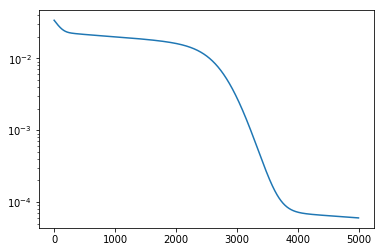

In [34]:
plt.plot(np.linspace(0,itr_F,itr_F), J_F[:itr_F]/I_F)
plt.yscale('log')
plt.show()

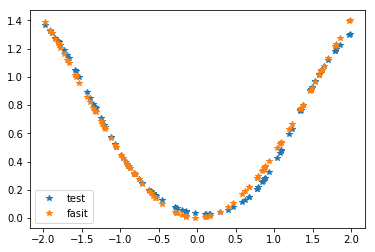

In [35]:
#testing with F(y)
YTest_F = np.random.uniform(-2,2,(1,I_F))
cTest_F = F(YTest_F)


ypsilonTest_F = testing(YTest_F, cTest_F, W_F, b_F, omega_F, mu_F, K, d_F, I_F, h, sigma, eta)

plt.figure()
plt.plot(YTest_F[0], ypsilonTest_F, "*", label = "test")
plt.plot(YTest_F[0], cTest_F[0], "*", label = "fasit")
plt.legend()
plt.show()

#### 3.2 G

In [ ]:
def G(y1, y2):
    return 1/2 *(y1**2 + y2**2)

In [ ]:
d_G = 4        #dimension of layers for F(y)
I_G = 1000     #input size 

#training with G(y)
Y0_G = np.random.uniform(-2,2,(2,I_G))
c_G = G(Y0_G[0],Y0_G[1])
c_G.resize(1,I_G)

Y0_G_tilde, aY0_G, bY0_G = scale(Y0_G)
c_G_tilde, ac_G, bc_G = scale(c_G)

In [ ]:
mu_G, omega_G, W_G, b_G, J_G, ypsilon_G, itr_G = trainingAlgorithm(K, d_G, h, tau, Y0_G_tilde, c_G_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_G, "adam")
writeParams(W_G, b_G, omega_G, mu_G, ypsilon_G, J_G, itr_G, filename = 'trainingParams_G.txt')

In [ ]:
W_Gr,b_Gr,omega_Gr,mu_Gr, ypsilon_Gr, J_G, itr_G = readParams(K, d_G, I_G, N, filename='trainingParams_G.txt')

In [ ]:
#plotting of objective function
plt.plot(np.linspace(0,itr_G,itr_G), J_G[:itr_G]/I_G)
plt.yscale("log")
plt.show()

In [ ]:
#testing with G(y)
YTest_G = np.random.uniform(-2,2,(2,I_G))
cTest_G = G(YTest_G[0], YTest_G[1])
cTest_G.resize(1,I_G)

ypsilonTest_G = testing(YTest_G, cTest_G, W_G, b_G, omega_G, mu_G, K, d_G, I_G, h, sigma, eta)


#plotting of G(y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(YTest_G[0], YTest_G[1], ypsilonTest_G, label = "test", depthshade = True)
ax.scatter(YTest_G[0], YTest_G[1], cTest_G[0], label = "test" , c="red", depthshade = False)
plt.show()

x = np.arange(0, I_G)
plt.plot(x, ypsilonTest_G, label ="test")
plt.plot(x, cTest_G[0], label = "fasit")
plt.legend()
plt.show()

### 4. Training with data given

In [ ]:
d_0 = 3
N_0 = 3000
K_0= 50


batch0 = generate_data()

p0_tilde, ap0,bp0 = scale(batch0['P'])
T0_tilde, aT0, bT0 = scale(batch0['T'])
T0_tilde.resize(1,T0_tilde.shape[0])

I_0 = p0_tilde.shape[1]

mu_0, omega_0, W_0, b_0, J_0, ypsilon_0, J_0 = trainingAlgorithm(K_0, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N_0,500, "adam")

In [ ]:
writeParams(W_0, b_0, omega_0, mu_0, ypsilon_0, filename = 'trainingParams_0.txt')

In [ ]:
W_0r,b_0r,omega_0r,mu_0r,ypsilon_0r = readParams(K_0, d_0, I_0, filename='trainingParams_0.txt')

In [ ]:
#plotting of objective function
plt.plot(np.linspace(0,N_0,N_0), J_0)
plt.yscale("log")
plt.show()

In [ ]:
x = np.arange(0, I_0)
ypsilon0_scaled = inverseScale(ypsilon_0, aT0, bT0)
T0 = batch0['T']

print(successrate(ypsilon0_scaled, T0, 0.0035))

plt.plot(x, ypsilon0_scaled, label ="test")
plt.plot(x, T0[0], label = "fasit")
plt.legend()
plt.show()

In [ ]:
#testing with batch 1

batch1 = generate_data(1)

p1 = batch1['P']
T1 =batch1['T']
T1.resize(1,T1.shape[0])


ypsilonTest_1 = testing(p1, T1, W_0, b_0, omega_0, mu_0, K_0, d_0, I_0, h, sigma, eta)



In [ ]:
x = np.arange(0, I_0)
plt.plot(x, ypsilonTest_1, label ="test")
plt.plot(x, T1[0], label = "fasit")
plt.legend()
plt.show()

In [ ]:
trainingBatch = concatenate(batchmin=0, batchmax=25)
I_T = trainingBatch["P"].shape[1]
d_T = trainingBatch["P"].shape[0]
batchsize = 50000

In [ ]:
pT_tilde, apT, bpT = scale(trainingBatch["P"])
TT_tilde, aTT, bTT = scale(trainingBatch["T"])
TT_tilde.resize(1,TT_tilde.shape[0])

mu_T, omega_T, W_T, b_T, J_T, ypsilon_T, itr_T = trainingAlgorithm(K, d_T, h, tau, pT_tilde, TT_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")

In [ ]:
W_T,b_T,omega_T,mu_T,ypsilon_T, J_T, itr_T = readParams(K, d_T, batchsize, N, filename='trainingParams_T.txt')

In [ ]:
plt.plot(np.linspace(0,itr_T,itr_T), J_T[:itr_T]/batchsize)
plt.yscale("log")
plt.show()

### larger batchsize

In [ ]:
trainingBatch = concatenate(0,25)

In [ ]:
dT = trainingBatch['P'].shape[0]
IT = trainingBatch['P'].shape[1]
batchsize = 50000

pT_tilde = trainingBatch['P']
TT_tilde, aTT, bTT = scale(trainingBatch['T'])
TT_tilde.resize(1,TT_tilde.shape[0])

In [ ]:
mu_T, omega_T, W_T, b_T, J_T, ypsilon_T, itr_T = trainingAlgorithm(K, dT, h, tau, pT_tilde, TT_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
writeParams(W_T, b_T, omega_T, mu_T, ypsilon_T, J_T, itr_T, filename = 'trainingParams_T.txt')

In [ ]:
W_T, b_T, omega_T, mu_T, ypsilon_T, J_T, itr_T = readParams(K, dT, batchsize, N, filename='trainingParams_T.txt')

In [ ]:
#plotting of objective function
plt.plot(np.linspace(0,itr_T,itr_T), J_T[:itr_T]/batchsize)
plt.yscale("log")
plt.show()

### 5. Computing the gradient 

In [ ]:
def getZ_oneData(y,W,b,K,h,sigma):
    d = y.shape[0]
    I = y.shape[1]
    Z = np.zeros((K,d,I))
    Z[0] = y
    
    for k in range(1,K):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def gradF(y, omega, mu, W, b, K, sigma, eta_div, sigma_div):
    Z = getZ_oneData(y, W, b, K, h, sigma)
    A = eta_div(np.transpose(Z[K-1])@omega + mu)*omega 
    for k in range(K-1,0,-1): 
        B = h*sigma_div(W[k]@y+b[k])
        u = B*A
        A = A + W[k]@u
    return A

### 6. Numerical methods 

In [ ]:
def symplecticEuler(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div): 

    q = np.zeros((len(t), q0.shape[0], q0.shape[1]))
    p = np.zeros((len(t), p0.shape[0], p0.shape[1]))
    
    q[0] = q0
    p[0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n] 

        q[n+1] = q[n] + delta_t*gradF(p[n], omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div) #dTdp
        p[n+1] = p[n] - delta_t*gradF(q[n+1], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #dVdq
    
    return q,p

In [ ]:
def Stromer_Verlet(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div): 
    
    q = np.zeros((len(t), q0.shape[0], q0.shape[1]))
    p = np.zeros((len(t), p0.shape[0], p0.shape[1]))
    
    q[0] = q0
    p[0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n] 
        u = p[n] - delta_t/2*gradF(q[n], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #u = p_{n+1/2}, dVdq
        q[n+1] = q[n] + delta_t*gradF(u, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div) #dTdp
        p[n+1] = u - delta_t/2*gradF(q[n+1], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #dVdq
    
    return q,p

#### 6.1 Nonlinear pendulum

In [ ]:
m = 10E-3
l = 0.5
g = 9.81

def T_pend(p):
    return 0.5*p**2

def V_pend(q):
    return m*g*l*(1-np.cos(q))

In [ ]:
I_p = 1000
d_p = 2

q_p = np.random.uniform(0,2*np.pi,(1,I_p))
V_p = V_pend(q_p)
V_p_tilde, aVp, bVp = scale(V_p)

In [ ]:
W_Tpend,b_Tpend,omega_Tpend,mu_Tpend,ypsilon_Tpend, J_Tpend, itr_Tpend = readParams(K, d_p, I_p, N, filename='trainingParams_Tp.txt')
W_Vpend,b_Vpend,omega_Vpend,mu_Vpend,ypsilon_Vpend, J_Vpend, itr_Vpend = readParams(K, d_p, I_p, N, filename='trainingParams_Vp.txt')

In [ ]:
q0 = np.zeros((d_p,1))
p0 = np.zeros((d_p,1))
t = np.linspace(0,10,100)

q_sympEuler, p_sympEuler = symplecticEuler(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, K, sigma, eta_div, sigma_div)

q_StromerVerlet, p_StromerVerlet = Stromer_Verlet(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, K, sigma, eta_div, sigma_div)

In [ ]:
q_plot = np.append(np.flip(q_sympEuler[:,0,:]),q_sympEuler[:,1,:])

q = np.linspace(-2,2,100)

plt.plot(q, V_pend(q), label = "fasit")
plt.plot(q_plot, V_pend(q_plot), "--", label = "Symplectic Euler")


plt.legend()


In [ ]:
q_plot = np.append(np.flip(q_StromerVerlet[:,0,:]),q_StromerVerlet[:,1,:])

q = np.linspace(-2,2,100)

plt.plot(q, V_pend(q), label = "fasit")
plt.plot(q_plot, V_pend(q_plot), "--", label = "Stromer Verlet")


plt.legend()
